In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.display import set_matplotlib_formats
sns.set_style("whitegrid")
%matplotlib inline
set_matplotlib_formats('svg')

Collect all data

In [4]:
dfs = []
dfs.append(pd.read_csv('../results/17824621.csv'))
dfs.append(pd.read_csv('../results/17827845.csv'))
dfs.append(pd.read_csv('../results/17827850.csv'))
dfs.append(pd.read_csv('../results/17827855.csv'))
dfs.append(pd.read_csv('../results/17827870.csv'))
dfs.append(pd.read_csv('../results/17838246.csv'))
dfs.append(pd.read_csv('../results/17838254.csv'))
dfs.append(pd.read_csv('../results/17873402.csv'))
data = pd.concat(dfs)
data = data.rename(columns={'hyperparam': 'n_components'})
data

,fold,n_components,error,walltime,cputime
0,1,1,38.83,00:12:05,00:54:23
1,2,1,40.65,00:12:05,00:54:23
2,3,1,40.24,00:12:05,00:54:23
3,4,1,38.77,00:12:05,00:54:23
4,5,1,39.13,00:12:05,00:54:23
...,...,...,...,...,...
35,6,19,40.65,23:30:04,9-11:25:55
36,7,19,43.98,23:30:04,9-11:25:55
37,8,19,39.37,23:30:04,9-11:25:55
38,9,19,42.41,23:30:04,9-11:25:55


Convert wall- and cputime to minutes.

Note walltime is total time spend to compute all folds, whilst cpu time is total **accumulated** time spent by each individual fold on training and testing the model.

In [5]:
def to_minutes(duration):
    '''converts duration to minutes.
    e.g. "00:54:23"   to 54.38 min
    e.g. "1-00:00:00" to 1440.00 min (= 1 day)'''
    days = duration.str.extract(r'(\d)-.*', expand=False)
    days = pd.to_numeric(days)
    timestamp = duration.str.replace(r'\d-', '')
    minutes = timestamp.apply(lambda x: pd.Timedelta(x).total_seconds() / 60)
    return minutes + days.fillna(0) * 24 * 60

data['walltime (minutes)'] = to_minutes(data['walltime'])
data['cputime (minutes)'] = to_minutes(data['cputime'])

Plot `n_components` versus error rate

Text(0, 0.5, 'Time (minutes)')

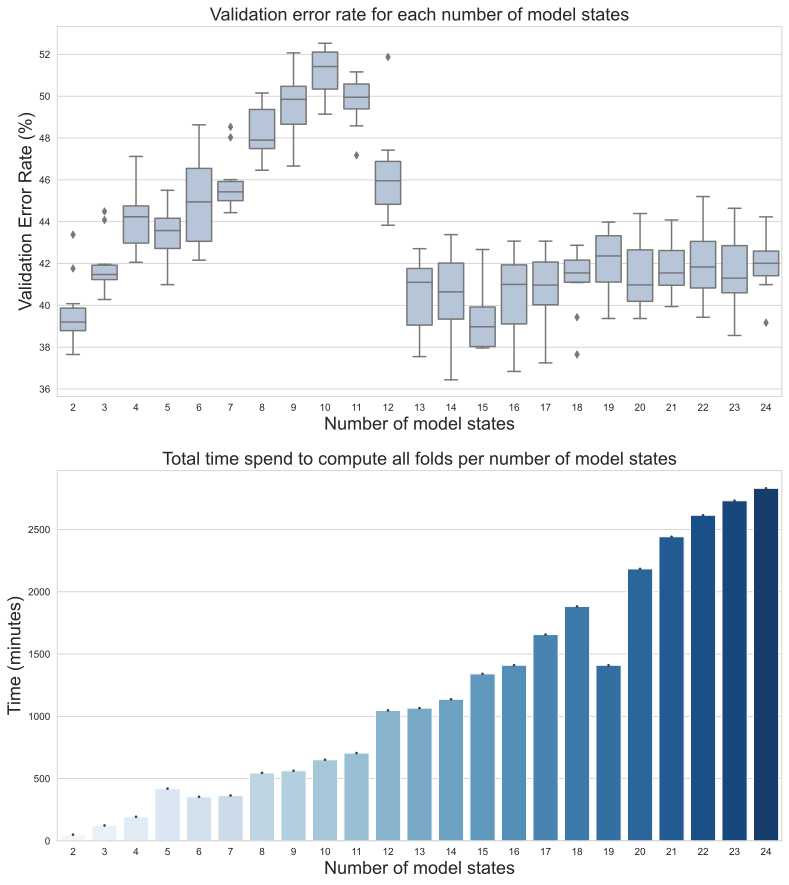

In [15]:
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(13,15))
sns.boxplot(data=data.loc[data.n_components > 1], x='n_components', y='error', ax=ax0, color="lightsteelblue")
ax0.set_title('Validation error rate for each number of model states', fontsize=18)
ax0.set_xlabel("Number of model states", fontsize=18)
ax0.set_ylabel("Validation Error Rate (%)", fontsize=18)

sns.barplot(data=data.loc[data.n_components > 1], x='n_components', y='walltime (minutes)', ax=ax1, palette="Blues")
ax1.set_title('Total time spend to compute all folds per number of model states', fontsize=18)
ax1.set_xlabel("Number of model states", fontsize=18)
ax1.set_ylabel("Time (minutes)", fontsize=18)

## HMM vs Naive method

Compare effect of subset sizes on performance

In [7]:
nm_10 = [100.00, 0.00, 0.00, 0.00, 100.00, 0.00, 0.00, 0.00, 0.00, 100.00]
nm_100 = [30.00, 60.00, 60.00, 50.00, 40.00, 80.00, 80.00, 50.00, 40.00, 70.00,]
nm_1000 = [56.00, 44.00, 50.00, 56.00, 43.00, 41.00, 47.00, 44.00, 46.00, 50.00]
nm_9889 = [47.83, 46.01, 44.99, 46.81, 46.61, 46.11, 46.96, 42.71, 45.55, 44.64]
naive_method = [nm_10, nm_100, nm_1000, nm_9889]

In [8]:
subsetdata = pd.read_csv('../results/17873366.csv')
subsetdata = subsetdata.rename(columns={'hyperparam': 'subset_size'})
subsetdata['n_components'] = 2
subsetdata['walltime (minutes)'] = to_minutes(subsetdata['walltime'])
subsetdata['cputime (minutes)'] = to_minutes(subsetdata['cputime'])
fullsubset = data[data['n_components'] == 2]
fullsubset['subset_size'] = 9889
subsetdata = pd.concat([subsetdata, fullsubset])
subsetdata.head()

<ipython-input-8-8f06bcda21e6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fullsubset['subset_size'] = 9889


,fold,subset_size,error,walltime,cputime,n_components,walltime (minutes),cputime (minutes)
0,1,10,100.0,00:01:23,00:00:42,2,1.383333,0.7
1,2,10,100.0,00:01:23,00:00:42,2,1.383333,0.7
2,3,10,100.0,00:01:23,00:00:42,2,1.383333,0.7
3,4,10,100.0,00:01:23,00:00:42,2,1.383333,0.7
4,5,10,100.0,00:01:23,00:00:42,2,1.383333,0.7


In [9]:
subsetdata["method"] = "hmm"
subsetdata = subsetdata[["method", "subset_size", "error"]]
subset_methods = pd.concat([subsetdata] + [pd.DataFrame([["naive", j, k[i]] for i in range(10)], columns=["method", "subset_size", "error"]) for j,k in zip([10, 100, 1000, 9889], naive_method)])

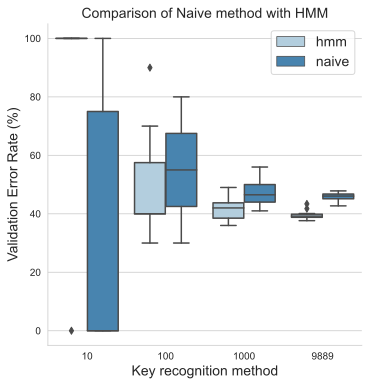

In [10]:
sns.catplot(data=subset_methods, x="subset_size", y="error", hue="method", kind="box", legend=False, palette="Blues")
plt.xlabel("Key recognition method", fontsize=14)
plt.ylabel("Validation Error Rate (%)", fontsize=14)
plt.title("Comparison of Naive method with HMM", fontsize=14)
plt.legend(fontsize=14)
plt.show()

Varying confidence levels

In [11]:
confdata = pd.read_csv('../results/17902559.csv')
confdata = confdata.rename(columns={'hyperparam': 'min_conf'})
confdata['Minimum key confidence'] = confdata['min_conf'] / 100
confdata = confdata.loc[confdata['Minimum key confidence'].isin(np.linspace(0, 1.0, 11))]
confdata.head()

,fold,min_conf,error,walltime,cputime,n,Minimum key confidence
0,1,0,39.27,01:27:01,08:09:04,9885,0.0
1,2,0,38.06,01:27:01,08:09:04,9885,0.0
2,3,0,41.76,01:27:01,08:09:04,9885,0.0
3,4,0,39.23,01:27:01,08:09:04,9885,0.0
4,5,0,38.97,01:27:01,08:09:04,9885,0.0


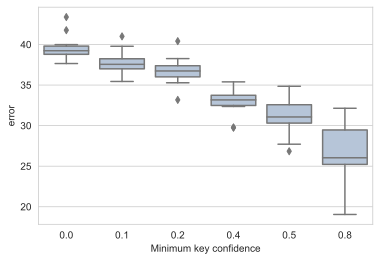

In [12]:
labs = sns.boxplot(data=confdata, x='Minimum key confidence', y='error', color='lightsteelblue')


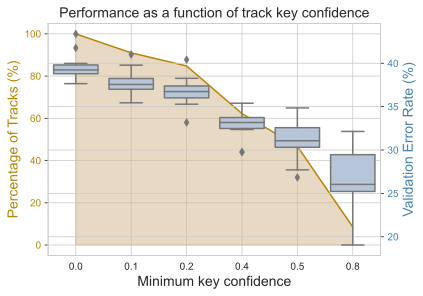

In [13]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Minimum key confidence', fontsize=14)
ax1.plot([t.get_text()  for t in labs.get_xticklabels()], confdata.n.unique()*100/9889, color='darkgoldenrod')
ax1.fill_between([t.get_text()  for t in labs.get_xticklabels()], confdata.n.unique()*100/9889, color='tan', alpha=0.5)
ax1.tick_params(axis='y', labelcolor='darkgoldenrod')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax1.set_ylabel('Percentage of Tracks (%)', fontsize=14, color='darkgoldenrod')  # we already handled the x-label with ax1
sns.boxplot(data=confdata, x='Minimum key confidence', y='error', color='lightsteelblue', ax=ax2)
ax2.tick_params(axis='y', labelcolor='steelblue')
ax2.set_ylabel('Validation Error Rate (%)', fontsize=14, color='steelblue')


fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.set_title('Performance as a function of track key confidence', fontsize=14)
plt.show()

Total CPU time spent

In [14]:
'{:.0f} hours spent computing on a CPU'.format(\
    data['cputime (minutes)'].sum()/60)

'35858 hours spent computing on a CPU'